Text(0, 0.5, 'optimal action prob')

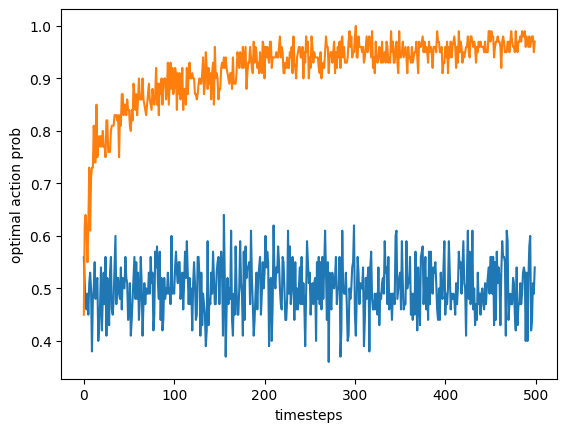

In [7]:
import matplotlib.pyplot as plt
import random

random.seed(1337)

epsilon: float = 0.05
reward_probs: list[list[float]] = [[0.1, 0.5, 0.4, 0.2], # M1
                                   [0.5, 0.1, 0.2, 0.4]] # M2

#reward_probs: list[list[float]] = [[0.25, 0.25, 0.25, 0.25], # M1
#                                   [0.75, 0.75, 0.75, 0.75]] # M2

def _prob_reward(successes, failures) -> list[list[float]]:
    prob_reward: list[list[float]] = [[0.0, 0.0], [0.0, 0.0]]
    # P(reward=1|intuition, action)
    for intuition in range(len(successes)):
        for action in range(len(successes[0])):
            success: int = successes[intuition][action]
            failure: int = failures[intuition][action]
            if success + failure > 0:
                prob_reward[intuition][action] = success / (success + failure)
            else:
                prob_reward[intuition][action] = 0.5
    return prob_reward

def _intuition(d: int, b: int) -> int:
    if d == 0 and b == 0:
        return 0
    elif d == 0 and b == 1:
        return 1
    elif d == 1 and b == 0:
        return 1
    elif d == 1 and b == 1:
        return 0
    else:
        raise Exception("Invalid state")

def run(contextual: bool):
    timesteps: int = 500
    samples: int = 100
    rewards: list[float] = [0.0] * timesteps
    probs_optimal_action: list[float] = [0.0] * timesteps
    for n in range(0, samples):
        successes: list[list[int]] = [[0, 0], [0, 0]]
        failures: list[list[int]] = [[0, 0], [0, 0]]
   
        for t in range(timesteps):
            d: int = random.choice([0, 1]) 
            b: int = random.choice([0, 1])
            if contextual:
                intuition: int = _intuition(d, b)
            else:
                intuition: int = 0

            covariate_index: int = b + d * 2
            exploring = (random.random() < epsilon)
            if exploring:
                action = int((random.random() < 0.5))
            else:
                # We just learn which action is better independent of the covariate
                values = _prob_reward(successes, failures)
                values = values[intuition]
                # values = [P(reward=1|action=0), P(reward=1|action=1)]
                max_actions: list[int] = [i for i, x in enumerate(values) if x == max(values)]
                action = random.choice(max_actions)

            reward_prob: float = reward_probs[action][covariate_index]
            reward: int = int(random.random() <= reward_prob)
            rewards[t] += reward/samples
            if contextual:
                successes[intuition][action] += reward
                failures[intuition][action] += 1 - reward
            else:
                successes[intuition][action] += reward
                failures[intuition][action] += 1 - reward

            probs: list[float] = [reward_probs[0][covariate_index], reward_probs[1][covariate_index]]
            best_action: int = probs.index(max(probs))
            if action == best_action:
                probs_optimal_action[t] += 1/samples
    return probs_optimal_action

probs_optimal_action = run(False)
assert sum(probs_optimal_action) == 250.69000000000017
probs_optimal_action_contextual = run(True)
assert sum(probs_optimal_action_contextual) == 458.30000000000024
plt.plot(probs_optimal_action)
plt.plot(probs_optimal_action_contextual)
plt.xlabel("timesteps")
plt.ylabel("optimal action prob")